# init
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de

## Tasks
- Generate individual polygons for each affected municipality <br>
- Download OSM roads and buildings for each affected municipality using OSMnX <br>
- Identify OSM road tracts and buildings intersecting with flooded area (outer join) <br>
- export to individual municipality roads datasets 
- export individual municipality affected roads lists
- export to individual municipality buildings datasets 

## Prerequisites
- have osmnx and geopandas installed
- have the maximum flooded area saved as a vector (shapefile or geopackage)
- have the municipalities as a vector

# defs

In [1]:
def osm_import(roi):
     
    roi_coords = roi.to_crs(epsg='4326').envelope
    #get road features from OSM
    # List key-value pairs for tags
    # Wiki url https://wiki.openstreetmap.org/wiki/Key:highway
    tags = {'highway': ['primary', 'secondary', 'tertiary', 'residential', 'unclassified', 'trunk', 'motorway']}
    col_list = ['osmid','name','source','geometry', 'highway'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns

    roads = ox.features_from_bbox(north=roi_coords.bounds.values[0][3],
                                south=roi_coords.bounds.values[0][1],
                                west=roi_coords.bounds.values[0][0],
                                east=roi_coords.bounds.values[0][2],
                                tags=tags)
    roads.reset_index(inplace=True)

    #filtering out the wrong geometries (POLYGON or POINT) and element types (NODE)
    roads = roads.loc[(roads.geometry.type=='LineString')&(roads.element_type == 'way'), col_list]
    #convert the CRS of roads to the same as AOI
    roads.to_crs(roi.crs,inplace=True)
    clipped_gdf = gpd.clip(roads, mask=roi, keep_geom_type=True)
    
    #return them
    return clipped_gdf

# imports

In [2]:
# import packages and libraries

import osmnx as ox
import geopandas as gpd
from pathlib import Path
import folium 


In [3]:
#input flooded area vector 

flood_path = Path('../data/processed/')
flood_file = 'HYD_maximum_flood_area_2024_binary_A.shp' 
flood_gdf = gpd.read_file(flood_path/flood_file)
flood_gdf.drop(['gridcode','area'], axis=1, inplace=True)

# import the municipality boundaries
mun_path = Path('../data/external/')
mun_file = 'LIM_RS_municipalites_2022_A.shp'
mun_gdf = gpd.read_file(mun_path/mun_file)
mun_gdf = mun_gdf[(mun_gdf['NM_MUN']!='Lagoa dos Patos')]

print('Flood CRS:', flood_gdf.crs,', Municipality CRS:', mun_gdf.crs)

Flood CRS: EPSG:32722 , Municipality CRS: EPSG:32722


# data management

## Joining

In [4]:
flood_gdf.dissolve()
flood_gdf.shape

(150, 2)

In [5]:
flood_gdf.explore("Id", legend=False)

In [5]:
join_gdf = mun_gdf.sjoin(flood_gdf,how='left',)
affected_mun = join_gdf[join_gdf['index_right'].notna()].dissolve('NM_MUN') #.index_right.dropna(axis=0, subset=['index_right'], inplace=True)
affected_mun.reset_index(inplace=True)
affected_mun

,NM_MUN,geometry,CD_MUN,SIGLA_UF,AREA_KM2,index_right,Id
0,Agudo,"POLYGON ((280783.563 6703228.671, 280675.755 6...",4300109,RS,534.624,131.0,2.0
1,Alvorada,"POLYGON ((492936.910 6675795.361, 492919.340 6...",4300604,RS,71.700,3.0,2.0
2,Arroio do Meio,"POLYGON ((411847.248 6752613.429, 411975.881 6...",4301008,RS,157.088,3.0,2.0
3,Arroio dos Ratos,"POLYGON ((421437.093 6668556.192, 421378.385 6...",4301107,RS,425.791,40.0,2.0
4,Barra do Ribeiro,"POLYGON ((471898.641 6647458.786, 472204.596 6...",4301909,RS,729.316,0.0,2.0
...,...,...,...,...,...,...,...
74,Venâncio Aires,"POLYGON ((384109.019 6717301.324, 383911.476 6...",4322608,RS,772.588,3.0,2.0
75,Vera Cruz,"POLYGON ((350157.500 6699362.116, 350034.264 6...",4322707,RS,309.621,86.0,2.0
76,Veranópolis,"POLYGON ((444228.397 6786584.884, 443912.133 6...",4322806,RS,289.397,147.0,2.0
77,Vespasiano Corrêa,"POLYGON ((424131.410 6781322.209, 423765.510 6...",4322855,RS,113.622,142.0,2.0


<Axes: >

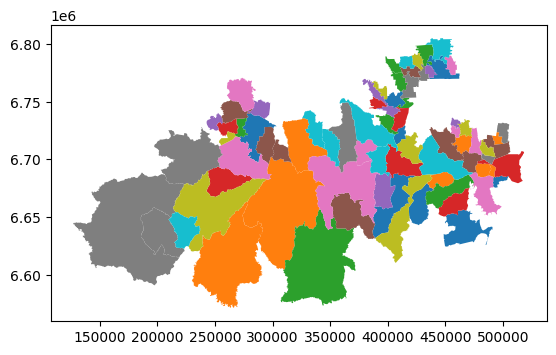

In [6]:
affected_mun.plot('NM_MUN')

## Getting BBOX for each municipality

<Axes: >

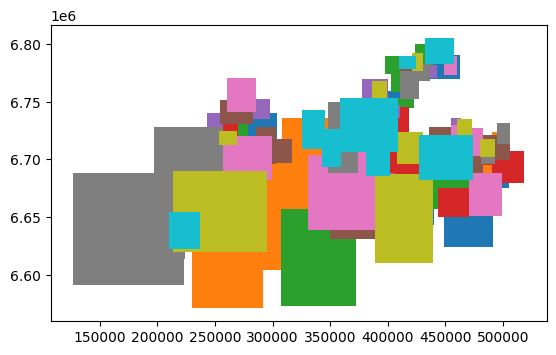

In [7]:
# extract a Bbox from each affected_mun feature
affected_mun_env =  affected_mun
affected_mun_env.geometry = affected_mun_env.envelope
affected_mun_env.plot('NM_MUN')


In [9]:
affected_mun_env.shape

(79, 7)

In [8]:
#setting the environment

AOI_path = Path('../data/processed/')
mun_file_list = []

# calling OSM in batches of 10

for mun in affected_mun_env.iloc[0:9].iterrows():
    #print(mun[1].geometry)
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    roi_roads.to_file(AOI_path / roi_file)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [14]:
# temp call, used when you have already downloaded all the files

for mun in affected_mun_env.iloc[0:78].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    #roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    #roi_roads.to_file(AOI_path / roi_file)

In [15]:
for mun in affected_mun_env.iloc[9:19].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    #roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    #roi_roads.to_file(AOI_path / roi_file)

In [16]:
for mun in affected_mun_env.iloc[19:29].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    roi_roads.to_file(AOI_path / roi_file)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [17]:
for mun in affected_mun_env.iloc[29:39].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    roi_roads.to_file(AOI_path / roi_file)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [18]:
for mun in affected_mun_env.iloc[39:49].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    roi_roads.to_file(AOI_path / roi_file)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [19]:
for mun in affected_mun_env.iloc[49:59].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    roi_roads.to_file(AOI_path / roi_file)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [20]:
for mun in affected_mun_env.iloc[59:69].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    roi_roads.to_file(AOI_path / roi_file)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

In [21]:
for mun in affected_mun_env.iloc[69:79].iterrows():
    roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
    roi_roads = osm_import(roi_gdf)
    roi_file = 'TRA_' + mun[1].NM_MUN + '_roads_OSM_2024_L.shp'
    mun_file_list.append(roi_file)
    roi_roads.to_file(AOI_path / roi_file)

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

## spatial join municipality highways with the flooded area

<Axes: >

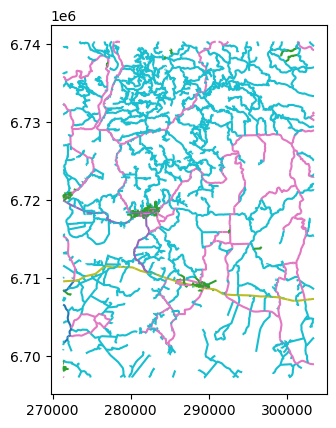

In [22]:
mun_gdf_list = []
mun_gdf_dict = {}
for file in mun_file_list:
    gpd_name = file.replace(' ','_').replace('.shp','')
    mun_gdf_list.append(gpd_name)

for i in range(len(mun_file_list)):
    mun_gdf_dict[mun_gdf_list[i]] = gpd.read_file(AOI_path / mun_file_list[i])

mun_gdf_dict[mun_gdf_list[0]].plot('highway')

<Axes: >

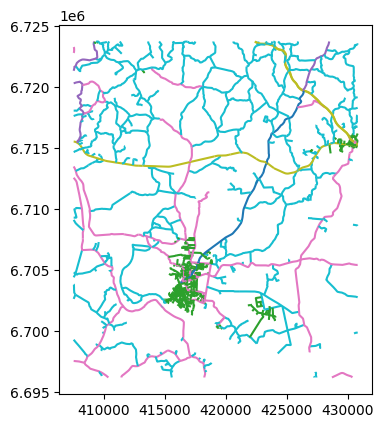

In [23]:
mun_gdf_dict[mun_gdf_list[78]].plot('highway')

In [26]:
joined_gdf_list = []
affected_gdf_list = []
joined_gdf_dict = {}
affected_gdf_dict = {}

for i in range(len(mun_gdf_list)):
    print(i, mun_gdf_list[i],mun_gdf_dict[mun_gdf_list[i]].shape)
    join_gdf_name =  mun_gdf_list[i] + '_join'
    joined_gdf_list.append(join_gdf_name)
    affected_gdf_name =  mun_gdf_list[i] + '_affected'
    affected_gdf_list.append(affected_gdf_name)

print(joined_gdf_list)

0 TRA_Agudo_roads_OSM_2024_L (3071, 5)
1 TRA_Alvorada_roads_OSM_2024_L (2957, 5)
2 TRA_Arroio_do_Meio_roads_OSM_2024_L (1345, 5)
3 TRA_Arroio_dos_Ratos_roads_OSM_2024_L (972, 5)
4 TRA_Barra_do_Ribeiro_roads_OSM_2024_L (553, 5)
5 TRA_Bento_Gonçalves_roads_OSM_2024_L (3184, 5)
6 TRA_Bom_Retiro_do_Sul_roads_OSM_2024_L (547, 5)
7 TRA_Butiá_roads_OSM_2024_L (1096, 5)
8 TRA_Cachoeira_do_Sul_roads_OSM_2024_L (2169, 5)
9 TRA_Agudo_roads_OSM_2024_L (3071, 5)
10 TRA_Alvorada_roads_OSM_2024_L (2957, 5)
11 TRA_Arroio_do_Meio_roads_OSM_2024_L (1345, 5)
12 TRA_Arroio_dos_Ratos_roads_OSM_2024_L (972, 5)
13 TRA_Barra_do_Ribeiro_roads_OSM_2024_L (553, 5)
14 TRA_Bento_Gonçalves_roads_OSM_2024_L (3184, 5)
15 TRA_Bom_Retiro_do_Sul_roads_OSM_2024_L (547, 5)
16 TRA_Butiá_roads_OSM_2024_L (1096, 5)
17 TRA_Cachoeira_do_Sul_roads_OSM_2024_L (2169, 5)
18 TRA_Cachoeirinha_roads_OSM_2024_L (2393, 5)
19 TRA_Campo_Bom_roads_OSM_2024_L (2827, 5)
20 TRA_Candelária_roads_OSM_2024_L (1713, 5)
21 TRA_Canoas_roads_OSM_20

In [27]:
# joining the segments for each municipality

for i in range(len(joined_gdf_list)):
    joined_gdf_dict[joined_gdf_list[i]] = mun_gdf_dict[mun_gdf_list[i]].sjoin(flood_gdf,how='left')
    affected_gdf_dict[affected_gdf_list[i]] = joined_gdf_dict[joined_gdf_list[i]][joined_gdf_dict[joined_gdf_list[i]]['index_right'].notna()] #.dissolve('osmid').reset_index(inplace=True)

In [ ]:
affected_gdf_dict

In [53]:
print(type(affected_gdf_dict[affected_gdf_list[78]]))
affected_gdf_dict[affected_gdf_list[78]]

<class 'geopandas.geodataframe.GeoDataFrame'>


,osmid,name,source,highway,geometry,index_right,Id
1,480107377,None,Bing,unclassified,"MULTILINESTRING ((428828.679 6772378.587, 4288...",135.0,2.0
2,332294706,None,Bing,unclassified,"LINESTRING (428526.875 6771391.483, 428551.558...",135.0,2.0
3,88968332,Rua Avelino Dalla Lasta,Bing,tertiary,"LINESTRING (428785.333 6772109.297, 428746.846...",135.0,2.0
6,737691349,Rua Irmã Maria Ester Picini,Bing,residential,"LINESTRING (428779.787 6772485.995, 428800.607...",135.0,2.0
22,696921644,None,Maxar Premium,unclassified,"LINESTRING (426481.417 6771054.588, 426444.497...",135.0,2.0
23,696921640,None,Maxar Premium,unclassified,"LINESTRING (426444.497 6771034.960, 426451.877...",135.0,2.0
24,332294705,None,Maxar Premium,unclassified,"LINESTRING (426391.681 6771056.027, 426406.602...",135.0,2.0
25,332294708,None,Bing,unclassified,"LINESTRING (426406.602 6771058.273, 426419.980...",135.0,2.0
40,88969363,Avenida Itália,Bing,tertiary,"LINESTRING (428536.091 6772486.235, 428549.299...",135.0,2.0
41,952941828,Avenida Itália,None,tertiary,"LINESTRING (428560.109 6772480.202, 428553.360...",135.0,2.0


## Buildings

# exports

In [62]:
print(affected_gdf_dict)

{'TRA_Agudo_roads_OSM_2024_L_affected':           osmid                    name source       highway  \
13    328624387                    None   None  unclassified   
14    328624385                    None   None  unclassified   
17    328628325                    None   None  unclassified   
18    450377206                    None   None  unclassified   
19    682184360                    None   None  unclassified   
...         ...                     ...    ...           ...   
2460  619018959                    None   None  unclassified   
2490  329160407                    None   None  unclassified   
2491  329160408                    None   None  unclassified   
2492  746825702  Estrada da Nova Boêmia   bing      tertiary   
2504  332774253                    None   None      tertiary   

                                               geometry  index_right   Id  
13    LINESTRING (298876.217 6701380.894, 298865.897...         38.0  2.0  
14    LINESTRING (298992.352 6701434.74

In [66]:
# export all affected GDFs as KMLs
AOI_path = Path('../data/processed/kml/')

for key in affected_gdf_dict.keys(): #range(len(affected_gdf_list))
    export_df = str(affected_gdf_dict[key])+'.kml'
    affected_gdf_dict[key].to_file(AOI_path / export_df, driver='KML')

DriverError: unsupported driver: 'KML'